Author: Cuong To Tu 

Email: {cuong}@statice.io

# Introduction to Approximate Inference

In this notebook, we review how to draw iid samples from a probabilistic model that is represented using a bayesian belief network (BN). From now on, instead of writing ``iid samples`` we will write ``samples``. If the samples are not iid, we will state that explicitly. But why do we need iid samples? This will be explained when the right time comes ;).

Being able to draw  samples from a probability distribution (model) allows us to perform approximate inference. The more samples we draw, the more accurate our inference becomes. All statistical methods that draw samples to perform inferences are called Monte Carlo methods. You may remember that variational inference are also approximate inference methods. What is the difference between them? The difference lies in how the approximation is done. In Monte Carlo methods, the approximation comes in the form of limited number of samples. Whereas, in variational inference, the approximation comes in how well the variational distribution family can capture the true posterior p(z|x). 


We illustrate each drawing approach by programming them ourself and using pyro. This is done so that we can understand better. Throughout this notebook, we will use a model called Normal-Normal, in which exact inference can be computed so that we can evaluate how good our approximate inference is.

### A Model: Normal-Normal conjugacy

Let $Y \mid \theta \sim \cal{N}(\theta, \sigma^2)$, where $\sigma^2$ is known but $\theta$ is unknown. Using Bayesian framework, we treat $\theta$ as a random variable, with prior given by $\theta \sim \cal{N}(\mu, \tau^2)$ for some known constants $\mu$ and $\sigma^2$. That is, we have a graphical model $\theta \rightarrow Y$:
$$\theta \sim \cal{N}(\mu, \tau^2) \\ Y \mid \theta \sim \cal{N}(\theta, \sigma^2).$$ 

**Question 1**:
> Suppose now we have one observation (data point) $Y=y$, what is the posterior $p(\theta|Y=y)$?

It happens that we can actually derive analytically the form of this posterior distribution. After observing Y = y, we have $$f_{\theta \mid y}(\theta \mid y) \propto f_{y\mid \theta}(y \mid \theta)f_{\theta}(\theta) \propto e^{-\frac{1}{2\sigma^2}(y-\theta)^2}e^{-\frac{1}{2\tau^2}(\theta-\mu)^2}.$$ 

By completing square, we can obtain an explitie formula for the posterior distribution of $\theta$:

![normal normal](gfx/normal_normal.jpg)

This is our true posterior distribution! Normally we do not have access to this density for model of practical interest. Let's assume that we do not know the above formula of $p(\theta |Y= y)$ then how do we **compute** it? We can approximate it! And there are two ways to do it, namely Monte-Carlo methods and Variational Inference.

First let's compute the true posterior distributions:

In [39]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad


%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

# reproducibility
np.random.seed(2018)

In [42]:
# model parameters
mu = 0,
tau_square = 1
sigma_square = 3

# true posterior p(\theta | Y=y)

# Monte-Carlo Approximate Inference
Suppose that we didn't know how to complete the square (we do not have the above formula). Or we just simply want to verify our formula for a specific values of $y, \sigma^2, \mu, \tau^2$. We can do this by simulating from the posteior distribution of $\theta$, using the Metropolis-Hastings algorithm to construct a Markov chain whose stationary distribution is $f_{\theta \mid y}(\theta \mid y)$.

We will use a particular Monte Carlo approximate inference algorithm called the Metropolis-Hastings algorithm  to find the posterior mean and variance of $\theta$ after observing the value of $Y$.

### Metropolis Hasting

We want to draw N samples $\{x^{(i)}\}_{i=1}^{N}$ from a density function p(x) upto a normalization factor, i.e. p(x) may not be a density function ($\int p(x)dx = d \neq 1$). The fact that we can draw from an unnormalized density function is important. Because we avoid compute the normalization factor, which can be intractable. 

The pseudocode for Metropolis-Hasting algorithm as follows.

1. Initialize $x^{(0)}$
2. For i = 0 to N-1
    - Sample $u \sim U_{[0,1]}$
    - Sample $x^* \sim q(x^* | x^{(i)})$
    - If $u < A(x^{(i)} , x^*) = min(1, \frac{p(x^*)q(x^{(i)}|x^{*})}{p(x^{(i)})q(x^*|x^{(i)})})$
        - $x^{(i+1)} = x^*$
    - Else
        - $x^{(i+1)} = x^{(i)}$

In [30]:
def metropolis_hastings_sample(p, q, x0 = 0, N=5000):
    x = np.zeros(N)
    x[0] = x0
    for i in range(N-1):
        u = np.random.rand()
        proposal = q(x[i]).rvs()
        acceptance = np.min([1, (p(proposal)*q(proposal).pdf(x[i]))/(p(x[i])*q(x[i]).pdf(proposal))])
        if u < acceptance:
            x[i+1] = proposal
        else:
            x[i+1] = x[i]
    return x

Let's use Metropolis-Hasting algorithm to draw samples from a normal distribution. 

In [31]:
# unnormalized target distribution
p = lambda x: 0.3*np.exp(-0.2*x**2) + 0.7*np.exp(-0.2*(x-10)**2)

# compute normalized factor, in general this is very expensive.
normalized_factor = quad(p, -10, 20)[0]

# proposal distribution
from scipy.stats import norm
q = lambda xi: norm(xi, 100)

# draw samples
samples = metropolis_hastings_sample(p,q)

/home/me/miniconda3/envs/dpp/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


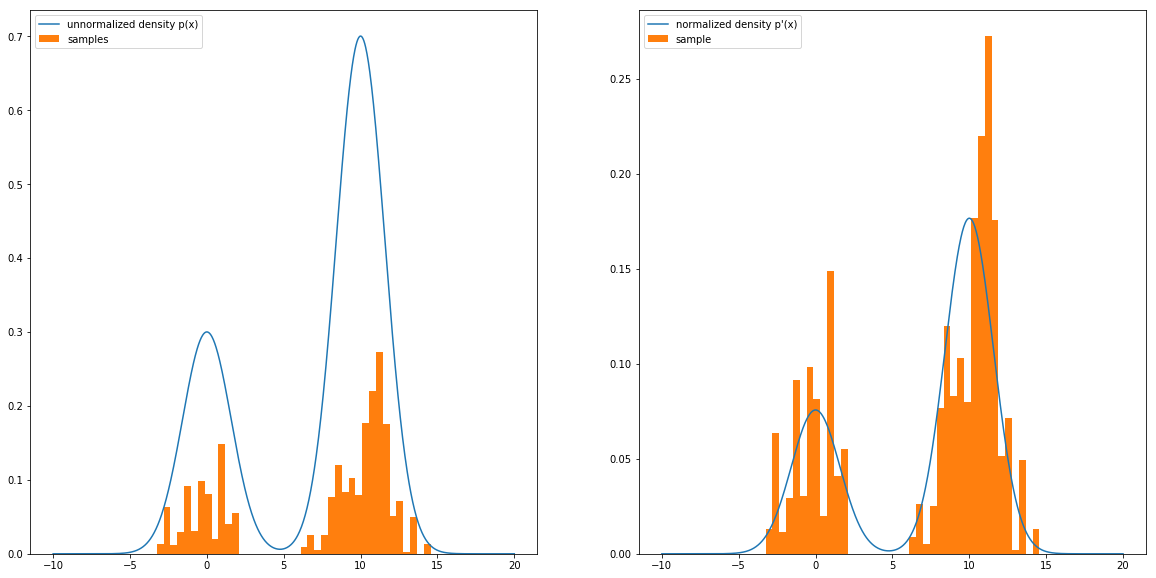

In [36]:
x = np.linspace(-10,20, 1000)
fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].plot(x,p(x), label='unnormalized density p(x)')
axes[0].hist(samples, bins=40,normed=True, label='samples');
axes[0].legend()


axes[1].plot(x,p(x)/normalized_factor, label='normalized density p\'(x)')
axes[1].hist(samples, bins=40,density=True, label='sample');
axes[1].legend()


### Metropolis-Hasting Inference on Normal-Normal Model

### Variational Inference